In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import xml.etree.ElementTree as ET

from imantics import Mask, Polygons

import os
import os.path as osp
import random

import mmcv

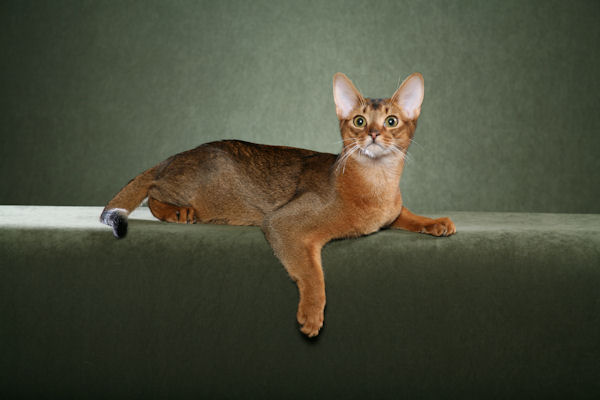

In [231]:
Image.open('images/Abyssinian_1.jpg')

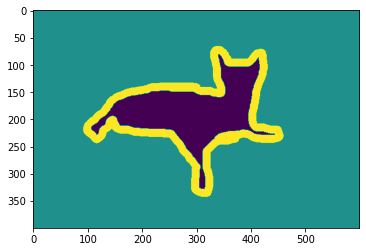

In [232]:
img = Image.open('annotations/trimaps/Abyssinian_1.png')
mask = plt.imshow(img)

In [233]:
# SOURCE - http://code.activestate.com/recipes/410469-xml-as-dictionary/


class XmlListConfig(list):

    def __init__(self, aList):
        for element in aList:
            if element:
                # treat like dict
                if len(element) == 1 or element[0].tag != element[1].tag:
                    self.append(XmlDictConfig(element))
                # treat like list
                elif element[0].tag == element[1].tag:
                    self.append(XmlListConfig(element))
            elif element.text:
                text = element.text.strip()
                if text:
                    self.append(text)


class XmlDictConfig(dict):
    '''
    Example usage:

    >>> tree = ElementTree.parse('your_file.xml')
    >>> root = tree.getroot()
    >>> xmldict = XmlDictConfig(root)

    Or, if you want to use an XML string:

    >>> root = ElementTree.XML(xml_string)
    >>> xmldict = XmlDictConfig(root)

    And then use xmldict for what it is... a dict.
    '''

    def __init__(self, parent_element):
        if parent_element.items():
            self.update(dict(parent_element.items()))
        for element in parent_element:
            if element:
                # treat like dict - we assume that if the first two tags
                # in a series are different, then they are all different.
                if len(element) == 1 or element[0].tag != element[1].tag:
                    aDict = XmlDictConfig(element)
                # treat like list - we assume that if the first two tags
                # in a series are the same, then the rest are the same.
                else:
                    # here, we put the list in dictionary; the key is the
                    # tag name the list elements all share in common, and
                    # the value is the list itself
                    aDict = {element[0].tag: XmlListConfig(element)}
                # if the tag has attributes, add those to the dict
                if element.items():
                    aDict.update(dict(element.items()))
                self.update({element.tag: aDict})
            # this assumes that if you've got an attribute in a tag,
            # you won't be having any text. This may or may not be a
            # good idea -- time will tell. It works for the way we are
            # currently doing XML configuration files...
            elif element.items():
                self.update({element.tag: dict(element.items())})
            # finally, if there are no child tags and no attributes, extract
            # the text
            else:
                self.update({element.tag: element.text})

In [234]:
tree = ET.parse('annotations/xmls/Abyssinian_1.xml')
root = tree.getroot()
xmldict = XmlDictConfig(root)

In [235]:
xmldict

{'filename': 'Abyssinian_1.jpg',
 'folder': 'OXIIIT',
 'object': {'bndbox': {'xmax': '425',
   'xmin': '333',
   'ymax': '158',
   'ymin': '72'},
  'difficult': '0',
  'name': 'cat',
  'occluded': '0',
  'pose': 'Frontal',
  'truncated': '0'},
 'segmented': '0',
 'size': {'depth': '3', 'height': '400', 'width': '600'},
 'source': {'annotation': 'OXIIIT',
  'database': 'OXFORD-IIIT Pet Dataset',
  'image': 'flickr'}}

In [238]:
def mask_to_points(mask):
    _mask = Mask(mask != 2)
    _polygons = Polygons.from_mask(_mask)
    shapes = _polygons.points
    lens = list(map(len, shapes))
    if len(lens) == 0:
        return None
    best_polygon = np.argsort(lens)[-1]
    polygon = shapes[best_polygon]
    return np.array(list(polygon) + [polygon[0]])

In [240]:
names = list(map(lambda e: e[:-4], list(os.listdir('images/'))))

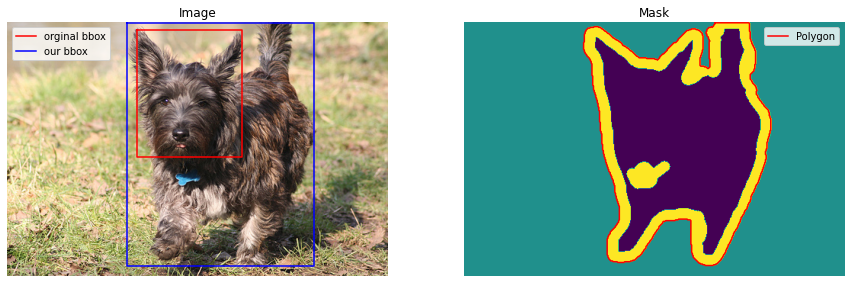

In [241]:
name = random.choice(names)
f, axs = plt.subplots(1, 2, figsize=(15, 8))
image = Image.open(f'images/{name}.jpg')
mask = np.array(Image.open(f'annotations/trimaps/{name}.png'))
tree = ET.parse(f'annotations/xmls/{name}.xml')
root = tree.getroot()
xmldict = XmlDictConfig(root)
xs = list(
    map(int, [
        xmldict['object']['bndbox']['xmin'],
        xmldict['object']['bndbox']['xmax'],
        xmldict['object']['bndbox']['xmax'],
        xmldict['object']['bndbox']['xmin'],
        xmldict['object']['bndbox']['xmin'],
    ]))
ys = list(
    map(int, [
        xmldict['object']['bndbox']['ymin'],
        xmldict['object']['bndbox']['ymin'],
        xmldict['object']['bndbox']['ymax'],
        xmldict['object']['bndbox']['ymax'],
        xmldict['object']['bndbox']['ymin'],
    ]))
points = mask_to_points(mask)
x_min, y_min, x_max, y_max = min(points[:, 0]), min(points[:, 1]), max(
    points[:, 0]), max(points[:, 1])
xs2 = [x_min, x_max, x_max, x_min, x_min]
ys2 = [y_min, y_min, y_max, y_max, y_min]
axs[0].imshow(image)
axs[0].set_title('Image')
axs[0].plot(xs, ys, color='red', label='orginal bbox')
axs[0].plot(xs2, ys2, color='blue', label='our bbox')
axs[0].axis('off')
axs[0].legend()
axs[1].imshow(mask)
axs[1].set_title('Mask')
axs[1].plot(points[:, 0], points[:, 1], color='red', label='Polygon')
axs[1].axis('off')
axs[1].legend()
plt.show()

In [243]:
def extract_class_name(image_name):
    i = 1
    while image_name[-i] != '_':
        i += 1
    return image_name[:-i]

In [244]:
class_names = [
    'Abyssinian', 'american_bulldog', 'american_pit_bull_terrier',
    'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer',
    'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel',
    'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese',
    'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon',
    'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug',
    'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier',
    'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier',
    'wheaten_terrier', 'yorkshire_terrier'
]

In [245]:
class_name_to_id = {name: id for id, name in enumerate(class_names)}

In [246]:
def convert_pets_to_coco(filenames, image_prefix, mask_prefix):
    annotations = []
    images = []
    classes = []
    for idx, filename in enumerate(filenames):
        img_path = osp.join(image_prefix, filename)
        image = Image.open(img_path)
        height, width = np.array(image).shape[:2]

        image_desc = dict(id=idx,
                          file_name=filename,
                          height=height,
                          width=width)

        mask_path = osp.join(mask_prefix, filename)
        mask_path = mask_path[:-3] + "png"
        mask = np.array(Image.open(mask_path))

        points = mask_to_points(mask)

        if points is None:
            continue

        poly = [(x + 0.5, y + 0.5) for x, y in points]
        poly = [p for x in poly for p in x]

        x_min, y_min, x_max, y_max = min(points[:, 0]), min(points[:, 1]), max(
            points[:, 0]), max(points[:, 1])

        anno = dict(image_id=idx,
                    id=idx,
                    category_id=class_name_to_id[extract_class_name(filename)],
                    bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                    area=(x_max - x_min) * (y_max - y_min),
                    segmentation=[poly],
                    iscrowd=0)

        annotations.append(anno)
        images.append(image_desc)

    for class_name, idx in class_name_to_id.items():
        desc = dict(id=idx,
                    name=class_name,
                    supercategory='Cat' if class_name[0].isupper() else 'Dog')
        classes.append(desc)

    coco_format_json = dict(images=images,
                            annotations=annotations,
                            categories=classes)

    return coco_format_json

In [250]:
names = list(os.listdir('images/'))
names = [name for name in names if name[-3:] == 'jpg']

In [198]:
coco_format_json = convert_pets_to_coco(names, 'images', 'annotations/trimaps')

In [212]:
mmcv.dump(coco_format_json, 'pets-full-coco-format.json')

In [248]:
test_names = []
with open('annotations/test.txt', 'r', encoding='utf8') as f:
    for line in f:
        test_names.append(line.split(' ')[0] + '.jpg')

In [251]:
all_files = set(names)

In [252]:
test_names = [name for name in test_names if name in all_files]

In [253]:
all_test_files = set(test_names)

In [258]:
train_names = [name for name in names if name not in all_test_files]

In [260]:
coco_format_json_train = convert_pets_to_coco(train_names, 'images',
                                              'annotations/trimaps')

In [261]:
coco_format_json_test = convert_pets_to_coco(test_names, 'images',
                                             'annotations/trimaps')

In [263]:
mmcv.dump(coco_format_json_train, 'pets-train-coco-format.json')

In [264]:
mmcv.dump(coco_format_json_test, 'pets-test-coco-format.json')

In [270]:
reduced_train_names = []
classes = set()
for name in train_names:
    class_name = extract_class_name(name)
    if class_name not in classes:
        reduced_train_names.append(name)
        classes.add(class_name)

        if len(reduced_train_names) == 37:
            break

In [272]:
reduced_test_names = []
classes = set()
for name in test_names:
    class_name = extract_class_name(name)
    if class_name not in classes:
        reduced_test_names.append(name)
        classes.add(class_name)

        if len(reduced_test_names) == 37:
            break

In [273]:
coco_format_json_train_37 = convert_pets_to_coco(reduced_train_names, 'images',
                                                 'annotations/trimaps')

In [274]:
coco_format_json_test_37 = convert_pets_to_coco(reduced_test_names, 'images',
                                                'annotations/trimaps')

In [275]:
mmcv.dump(coco_format_json_train_37, 'pets-train-37-coco-format.json')

In [276]:
mmcv.dump(coco_format_json_test_37, 'pets-test-37-coco-format.json')